In [1]:
import pandas as pd
import numpy as np
import math
from pyomo.environ import *
from pyomo.opt import SolverFactory
import os
solver_location = "C:\\Users\\DeepakYadav\\OneDrive - Tata Insights and Quants\\Optimization\\Scheduling\\cbc"
os.chdir(r'C:\\Users\\DeepakYadav\\OneDrive - Tata Insights and Quants\\Optimization\\Scheduling')

In [2]:
df = pd.read_excel('Problem1.xlsx',sheet_name = 'Sheet1',usecols = 'A:E')

In [3]:
df_melt = pd.melt(df, id_vars=['Machines'],value_vars = ['Job 1','Job2','Job3','Job4'],var_name = 'Jobs',value_name = 'Processing_time')

In [4]:
df_melt.set_index(['Machines','Jobs'], inplace = True)

In [5]:
# #DefiningSets
s_comb = list(set(df_melt.index))

s_m = [x[0] for x in df_melt.index]
s_M = list(set(s_m))
s_m = list(set(s_m))

s_i = [x[1] for x in df_melt.index]
s_j = list(set(s_i))
s_i = list(set(s_i))

In [6]:
#DefiningParams
p_processing_time = df_melt['Processing_time'].to_dict()

In [7]:
#DefiningVaraibles
model = ConcreteModel()

u = sum(p_processing_time[j,m] for (j,m) in s_comb)

model.v_start = Var(s_m,s_i, domain = NonNegativeReals)
model.v_finish = Var(s_m,s_i,domain = NonNegativeReals)
model.v_makespan = Var(domain = NonNegativeReals)
model.v_engage = Var(s_m,s_i,s_j, domain = Binary)
model.v_engage2 = Var(s_m,s_M,s_i, domain = Binary)

In [8]:
#DefiningConstraints
def finish_rule(model,m,i):
    return model.v_finish[m,i] >= model.v_start[m,i] + p_processing_time[m,i]
model.C2 = Constraint(s_m, s_i, rule = finish_rule)

def overlapping1_rule(model,m,i,j):
    if j != i:
        return model.v_start[m,j] + 1000 * (1 - model.v_engage[m,i,j]) >= model.v_start[m,i] + p_processing_time[m,i]   
    else:
        return Constraint.Skip
model.overlapping1 = Constraint(s_m ,s_i ,s_j, rule = overlapping1_rule)

def overlapping2_rule(model,m,i,j):
    if j != i:
        return model.v_start[m,i] + 1000 * model.v_engage[m,i,j] >= model.v_start[m,j] + p_processing_time[m,j] 
    else:
        return Constraint.Skip
model.overlapping2 = Constraint(s_m,s_i,s_j, rule = overlapping2_rule)

def makespan_rule(model,m,i):
    return model.v_makespan >= model.v_finish[m,i]
model.makespan = Constraint(s_m,s_i, rule = makespan_rule)

def overlapping3_rule(model,m,M,i):
    if M != m:
        return model.v_start[M,i] + 1000 * (1 - model.v_engage2[m,M,i]) >= model.v_start[m,i] + p_processing_time[m,i]   
    else:
        return Constraint.Skip
model.overlapping3 = Constraint(s_m ,s_M ,s_j, rule = overlapping3_rule)

def overlapping4_rule(model,m,M,i):
    if M != m:
        return model.v_start[m,i] + 1000 * model.v_engage2[m,M,i] >= model.v_start[M,i] + p_processing_time[M,i] 
    else:
        return Constraint.Skip
model.overlapping4 = Constraint(s_m,s_M,s_j, rule = overlapping4_rule)

In [9]:
#DefiningObjective
model.cost = Objective(expr=model.v_makespan,sense=minimize)

In [10]:
#Run Model
optimizer = SolverFactory("cbc", executable = solver_location)
#optimizer.options['ratio'] = 7e-2
results = optimizer.solve(model,tee=True) 
results.write()
print("Optimal Solution:")

Welcome to the CBC MILP Solver 
Version: 2.10 
Build Date: Oct 13 2019 

command line - C:\Users\DeepakYadav\OneDrive - Tata Insights and Quants\Optimization\Scheduling\cbc.exe -printingOptions all -import C:\Users\DEEPAK~1\AppData\Local\Temp\tmp_55hh0lj.pyomo.lp -stat=1 -solve -solu C:\Users\DEEPAK~1\AppData\Local\Temp\tmp_55hh0lj.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 144 (0) rows, 85 (0) columns and 408 (0) elements
Statistics for presolved model
Original problem has 60 integers (60 of which binary)
==== 84 zero objective 2 different
84 variables have objective of 0
1 variables have objective of 1
==== absolute objective values 2 different
84 variables have objective of 0
1 variables have objective of 1
==== for integers 60 zero objective 1 different
60 variables have objective of 0
==== for integers absolute objective values 1 different
60 variables have objective of 0
===== end objective counts


Problem has 144 rows, 85 colu

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 10.0
  Upper bound: 10.0
  Number of objectives: 1
  Number of constraints: 144
  Number of variables: 85
  Number of binary variables: 60
  Number of integer variables: 60
  Number of nonzeros: 1
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.66
  Wallclock time: 0.66
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 

In [11]:
model.v_start.pprint()

v_start : Size=12, Index=v_start_index
    Key                    : Lower : Value : Upper : Fixed : Stale : Domain
    ('Machine 1', 'Job 1') :     0 :   8.0 :  None : False : False : NonNegativeReals
     ('Machine 1', 'Job2') :     0 :   7.0 :  None : False : False : NonNegativeReals
     ('Machine 1', 'Job3') :     0 :   4.0 :  None : False : False : NonNegativeReals
     ('Machine 1', 'Job4') :     0 :   0.0 :  None : False : False : NonNegativeReals
    ('Machine 2', 'Job 1') :     0 :   4.0 :  None : False : False : NonNegativeReals
     ('Machine 2', 'Job2') :     0 :   9.0 :  None : False : False : NonNegativeReals
     ('Machine 2', 'Job3') :     0 :   0.0 :  None : False : False : NonNegativeReals
     ('Machine 2', 'Job4') :     0 :   6.0 :  None : False : False : NonNegativeReals
    ('Machine 3', 'Job 1') :     0 :   0.0 :  None : False : False : NonNegativeReals
     ('Machine 3', 'Job2') :     0 :   5.0 :  None : False : False : NonNegativeReals
     ('Machine 3', 'Job3'

In [12]:
model.v_finish.pprint()

v_finish : Size=12, Index=v_finish_index
    Key                    : Lower : Value : Upper : Fixed : Stale : Domain
    ('Machine 1', 'Job 1') :     0 :   9.0 :  None : False : False : NonNegativeReals
     ('Machine 1', 'Job2') :     0 :   8.0 :  None : False : False : NonNegativeReals
     ('Machine 1', 'Job3') :     0 :   7.0 :  None : False : False : NonNegativeReals
     ('Machine 1', 'Job4') :     0 :   3.0 :  None : False : False : NonNegativeReals
    ('Machine 2', 'Job 1') :     0 :   6.0 :  None : False : False : NonNegativeReals
     ('Machine 2', 'Job2') :     0 :  10.0 :  None : False : False : NonNegativeReals
     ('Machine 2', 'Job3') :     0 :   4.0 :  None : False : False : NonNegativeReals
     ('Machine 2', 'Job4') :     0 :   9.0 :  None : False : False : NonNegativeReals
    ('Machine 3', 'Job 1') :     0 :   4.0 :  None : False : False : NonNegativeReals
     ('Machine 3', 'Job2') :     0 :   7.0 :  None : False : False : NonNegativeReals
     ('Machine 3', 'Job

In [13]:
model.v_engage.pprint()

v_engage : Size=48, Index=v_engage_index
    Key                             : Lower : Value : Upper : Fixed : Stale : Domain
    ('Machine 1', 'Job 1', 'Job 1') :     0 :  None :     1 : False :  True : Binary
     ('Machine 1', 'Job 1', 'Job2') :     0 :   0.0 :     1 : False : False : Binary
     ('Machine 1', 'Job 1', 'Job3') :     0 :   0.0 :     1 : False : False : Binary
     ('Machine 1', 'Job 1', 'Job4') :     0 :   0.0 :     1 : False : False : Binary
     ('Machine 1', 'Job2', 'Job 1') :     0 :   1.0 :     1 : False : False : Binary
      ('Machine 1', 'Job2', 'Job2') :     0 :  None :     1 : False :  True : Binary
      ('Machine 1', 'Job2', 'Job3') :     0 :   0.0 :     1 : False : False : Binary
      ('Machine 1', 'Job2', 'Job4') :     0 :   0.0 :     1 : False : False : Binary
     ('Machine 1', 'Job3', 'Job 1') :     0 :   1.0 :     1 : False : False : Binary
      ('Machine 1', 'Job3', 'Job2') :     0 :   1.0 :     1 : False : False : Binary
      ('Machine 1', 'Job

In [14]:
model.overlapping1.pprint()

overlapping1 : Size=36, Index=overlapping1_index, Active=True
    Key                            : Lower : Body                                                                                                 : Upper : Active
    ('Machine 1', 'Job 1', 'Job2') :  -Inf : v_start[Machine 1,Job 1] + 1 - (v_start[Machine 1,Job2] + 1000*(1 - v_engage[Machine 1,Job 1,Job2])) :   0.0 :   True
    ('Machine 1', 'Job 1', 'Job3') :  -Inf : v_start[Machine 1,Job 1] + 1 - (v_start[Machine 1,Job3] + 1000*(1 - v_engage[Machine 1,Job 1,Job3])) :   0.0 :   True
    ('Machine 1', 'Job 1', 'Job4') :  -Inf : v_start[Machine 1,Job 1] + 1 - (v_start[Machine 1,Job4] + 1000*(1 - v_engage[Machine 1,Job 1,Job4])) :   0.0 :   True
    ('Machine 1', 'Job2', 'Job 1') :  -Inf : v_start[Machine 1,Job2] + 1 - (v_start[Machine 1,Job 1] + 1000*(1 - v_engage[Machine 1,Job2,Job 1])) :   0.0 :   True
     ('Machine 1', 'Job2', 'Job3') :  -Inf :   v_start[Machine 1,Job2] + 1 - (v_start[Machine 1,Job3] + 1000*(1 - v_engage[

In [15]:
model.overlapping2.pprint()

overlapping2 : Size=36, Index=overlapping2_index, Active=True
    Key                            : Lower : Body                                                                                           : Upper : Active
    ('Machine 1', 'Job 1', 'Job2') :  -Inf : v_start[Machine 1,Job2] + 1 - (v_start[Machine 1,Job 1] + 1000*v_engage[Machine 1,Job 1,Job2]) :   0.0 :   True
    ('Machine 1', 'Job 1', 'Job3') :  -Inf : v_start[Machine 1,Job3] + 3 - (v_start[Machine 1,Job 1] + 1000*v_engage[Machine 1,Job 1,Job3]) :   0.0 :   True
    ('Machine 1', 'Job 1', 'Job4') :  -Inf : v_start[Machine 1,Job4] + 3 - (v_start[Machine 1,Job 1] + 1000*v_engage[Machine 1,Job 1,Job4]) :   0.0 :   True
    ('Machine 1', 'Job2', 'Job 1') :  -Inf : v_start[Machine 1,Job 1] + 1 - (v_start[Machine 1,Job2] + 1000*v_engage[Machine 1,Job2,Job 1]) :   0.0 :   True
     ('Machine 1', 'Job2', 'Job3') :  -Inf :   v_start[Machine 1,Job3] + 3 - (v_start[Machine 1,Job2] + 1000*v_engage[Machine 1,Job2,Job3]) :   0.0 :   T

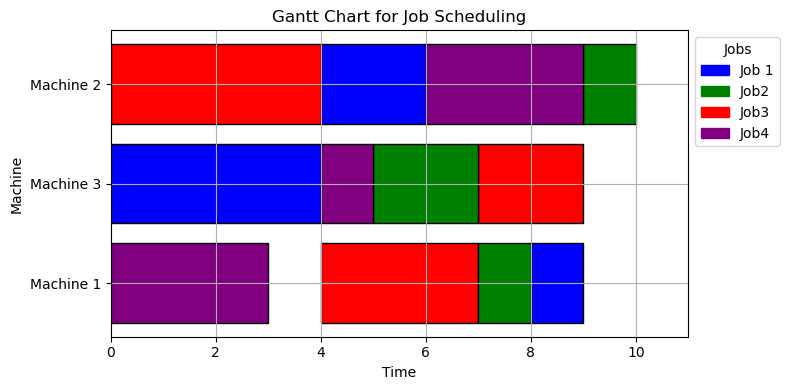

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Extract start and finish times
start_times = {(j, i): model.v_start[j, i].value for i in s_i for j in s_m}
finish_times = {(j, i): model.v_finish[j,i].value for i in s_i for j in s_m}

# Define colors for different jobs
job_colors = {
    'Job 1': 'blue',
    'Job2': 'green',
    'Job3': 'red',
    'Job4': 'purple'
}

# Create a Gantt chart
fig, ax = plt.subplots(figsize=(8 ,4))

for j in s_m:
    for i in s_i:
        start = start_times[j,i]
        end = finish_times[j,i]
        width = end - start
        color = job_colors[i]
        ax.barh(str(j), width, left=start, color=color, edgecolor='black')

# Customize the appearance of the chart
ax.set_xlabel('Time')
ax.set_ylabel('Machine')
ax.set_title('Gantt Chart for Job Scheduling')
ax.invert_yaxis()  
ax.set_xlim(0, max(finish_times.values()) + 1) 


legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in job_colors.values()]
legend_labels = [f'{i}' for i in job_colors.keys()]
ax.legend(legend_handles, legend_labels, title='Jobs', loc='upper left', bbox_to_anchor=(1, 1))

plt.grid(True)
plt.tight_layout()  
plt.show()


# Comments